In [1]:
import numpy as np

### 완전연결계층에 의한 변환

In [2]:
c = np.array([[1, 0, 0, 0, 0, 0, 0]])           # 입력
W = np.random.randn(7, 3)                       # 가중치
h = np.matmul(c, W)                             # 중간 노드
print(h)

[[ 0.85260206 -0.05899929  0.09626603]]


In [3]:
import sys
sys.path.append('..')
from common.layers import MatMul

layer = MatMul(W)
h = layer.forward(c)

print(h)

[[ 0.85260206 -0.05899929  0.09626603]]


## CBOW(Continuous Bag-Of-Words)

#### 맥락(주변 단어)으로부터 타깃(중앙 단어)을 추측하는 용도의 신경망

In [4]:
# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[-0.26205701 -1.04228914  0.10749083  1.18039164 -0.46028056  0.79401152
  -1.61059528]]


In [5]:
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word2id, id2word = preprocess(text)
print(corpus)
print(id2word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [8]:
## 맥락과 타깃을 만드는 함수

def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [9]:
contexts, target = create_contexts_target(corpus, window_size=1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [10]:
## 원핫 데이터로 변환하기
from common.util import convert_one_hot

vocab_size = len(word2id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

### 간단한 CBOW 구현하기

In [18]:
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    # 순전파
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)

        return loss

    # 역전파
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        
        return None

### 학습하기

|  반복 1 / 2 | 시간 0[s] | 손실 0.49
| 에폭 514 |  반복 1 / 2 | 시간 0[s] | 손실 0.55
| 에폭 515 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 516 |  반복 1 / 2 | 시간 0[s] | 손실 0.48
| 에폭 517 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 518 |  반복 1 / 2 | 시간 0[s] | 손실 0.54
| 에폭 519 |  반복 1 / 2 | 시간 0[s] | 손실 0.54
| 에폭 520 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 521 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 522 |  반복 1 / 2 | 시간 0[s] | 손실 0.50
| 에폭 523 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 524 |  반복 1 / 2 | 시간 0[s] | 손실 0.45
| 에폭 525 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 526 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 527 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 528 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 529 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 530 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 531 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 532 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 533 |  반복 1 / 2 | 시간 0[s] | 손실 0.44
| 에폭 534 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 535 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 536 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 537 |  반복 1 / 2 | 시간

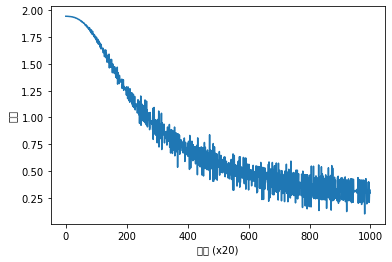

In [19]:
from common.trainer import Trainer
from common.optimizer import Adam

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, wrd2id, id2wrd = preprocess(text)

vocab_size = len(wrd2id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [20]:
# 가중치 매개변수 확인하기

word_vecs = model.word_vecs
for word_id, word in id2wrd.items():
    print(word, word_vecs[word_id])

you [-1.0526689 -0.8571643  1.7216244  1.0076574  1.0858552]
say [ 1.2739835   0.57853013  1.1616002   0.11224822 -1.2509232 ]
goodbye [-1.077474   -0.9911143  -0.7707457   0.75467896  1.0994108 ]
and [ 0.8490776  1.5452658  1.2006112 -1.6737765 -0.8414177]
i [-1.1042    -0.9876136 -0.7633492  0.7335472  1.0878184]
hello [-1.0452666  -0.85457224  1.7004702   1.0273439   1.0836431 ]
. [ 1.2301624 -1.5389888  0.668328   1.4189525 -1.2269148]
